In [1]:
!nvidia-smi

Sun Aug 31 12:27:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pcbreviglieri/pneumonia-xray-images")

print("Path to dataset files:", path)

100%|██████████| 1.14G/1.14G [00:13<00:00, 91.5MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/pcbreviglieri/pneumonia-xray-images/versions/1


In [4]:
os.listdir(path)

['test', 'train', 'val']

In [5]:
train_path = os.path.join(path, 'train')
train_path

'/root/.cache/kagglehub/datasets/pcbreviglieri/pneumonia-xray-images/versions/1/train'

In [6]:
classes = os.listdir(train_path)
classes

['opacity', 'normal']

In [7]:
normal_path = os.path.join(train_path, 'NORMAL')
pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

In [8]:
normal_path

'/root/.cache/kagglehub/datasets/pcbreviglieri/pneumonia-xray-images/versions/1/train/NORMAL'

In [9]:
pneumonia_path

'/root/.cache/kagglehub/datasets/pcbreviglieri/pneumonia-xray-images/versions/1/train/PNEUMONIA'


Sample image files in 'normal' class:
['NORMAL2-IM-0875-0001.jpeg', 'NORMAL2-IM-0812-0001.jpeg', 'NORMAL2-IM-0935-0001.jpeg', 'NORMAL2-IM-0395-0001-0002.jpeg', 'NORMAL2-IM-0493-0001.jpeg']

Sample image files in 'opacity' class:
['person51_bacteria_244.jpeg', 'person256_virus_537.jpeg', 'person371_bacteria_1695.jpeg', 'person355_virus_730.jpeg', 'person583_virus_1127.jpeg']


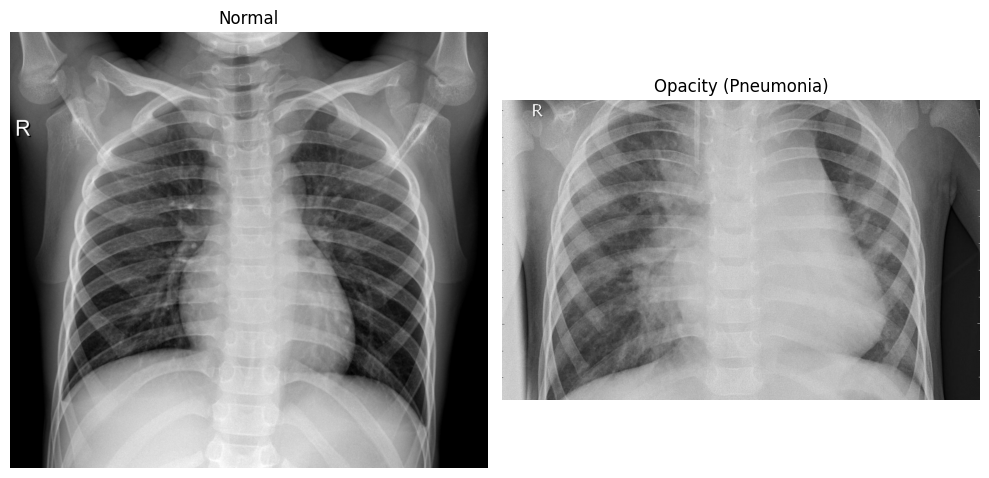

In [10]:
normal_path = os.path.join(train_path, 'normal')
opacity_path = os.path.join(train_path, 'opacity')

print("\nSample image files in 'normal' class:")
print(os.listdir(normal_path)[:5])

print("\nSample image files in 'opacity' class:")
print(os.listdir(opacity_path)[:5])

# Load and display a few sample images
plt.figure(figsize=(10, 5))

# Display a normal image
normal_img_path = os.path.join(normal_path, os.listdir(normal_path)[0])
normal_img = Image.open(normal_img_path)
plt.subplot(1, 2, 1)
plt.imshow(normal_img, cmap='gray')
plt.title('Normal')
plt.axis('off')

# Display an opacity image (representing pneumonia)
opacity_img_path = os.path.join(opacity_path, os.listdir(opacity_path)[0])
opacity_img = Image.open(opacity_img_path)
plt.subplot(1, 2, 2)
plt.imshow(opacity_img, cmap='gray')
plt.title('Opacity (Pneumonia)')
plt.axis('off')

plt.tight_layout()
plt.show()

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

import tensorflow as tf

In [12]:
train_dir = os.path.join(path, 'train')
val_dir = os.path.join(path, 'val')
test_dir = os.path.join(path, 'test')

img_size = (350, 350)
batch_size = 32

In [13]:
# Create ImageDataGenerators
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

In [14]:
# No data augmentation for validation and test, only rescaling
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 4192 images belonging to 2 classes.


In [16]:
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale'
)

Found 1040 images belonging to 2 classes.


In [17]:
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False, # Keep data in order for evaluation
    color_mode='grayscale'
)

Found 624 images belonging to 2 classes.


In [18]:
print("Data generators created:")
print(f"Training generator: {train_generator}")
print(f"Validation generator: {validation_generator}")
print(f"Test generator: {test_generator}")

Data generators created:
Training generator: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7b090ea700e0>
Validation generator: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7b09ac45fb30>
Test generator: <keras.src.legacy.preprocessing.image.DirectoryIterator object at 0x7b090ea70c20>


In [19]:
batchX, batchY = next(train_generator)
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(32, 350, 350, 1), min=0.000, max=1.000


In [20]:
labels = list(train_generator.class_indices.keys())
labels

['normal', 'opacity']

In [21]:
Counter(train_generator.classes)

Counter({np.int32(0): 1082, np.int32(1): 3110})

In [22]:
weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_generator.classes), y = train_generator.classes)
weights

array([1.93715342, 0.67395498])

In [23]:
cw = dict(zip(np.unique(train_generator.classes), weights))
cw

{np.int32(0): np.float64(1.9371534195933457),
 np.int32(1): np.float64(0.6739549839228296)}

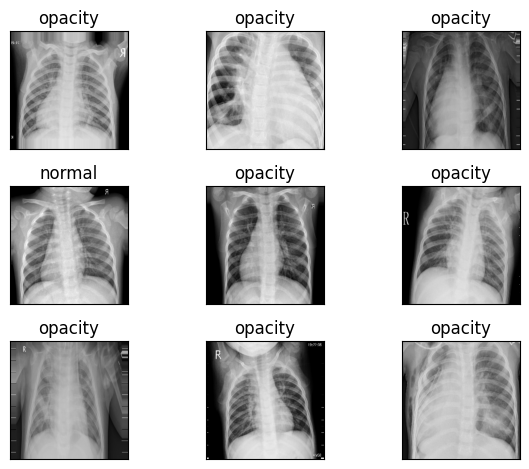

In [24]:
for i in range(9):
    ax = plt.subplot(3, 3, 1+i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title('%s'%(labels[int(batchY[i])]))
    plt.imshow(batchX[i][:,:,0], cmap=plt.get_cmap('gray'))

plt.tight_layout()
plt.savefig('chest_xray.png', dpi=300)

In [25]:
input_shape = (350, 350, 1)

# Input
inputs = tf.keras.Input(shape=input_shape)

# Feature Extraction
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='last_conv_layer')(x)

# Image Classification
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Model
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [26]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 350, 350, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 348, 348, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 174, 174, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 172, 172, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 86, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 84, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 42, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 40, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv_layer (Conv2D)        │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,700,897 (25.56 MB)

 Trainable params: 6,700,897 (25.56 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
ReduceLROnPlateau = tf.keras.callbacks.ReduceLROnPlateau

In [28]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.1, min_lr=0.000001)
callbacks_list = [learning_rate_reduction]

In [29]:
# Train the model
epochs = 10
history = model.fit(
    train_generator,
    callbacks=callbacks_list,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    class_weight=cw # Apply class weights to handle imbalance
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 102s 681ms/step - accuracy: 0.6271 - loss: 0.6109 - val_accuracy: 0.8604 - val_loss: 0.3565 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 120s 590ms/step - accuracy: 0.8825 - loss: 0.2704 - val_accuracy: 0.7480 - val_loss: 0.5703 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 81s 586ms/step - accuracy: 0.8857 - loss: 0.2689 - val_accuracy: 0.9365 - val_loss: 0.1567 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 598ms/step - accuracy: 0.9135 - loss: 0.1968 - val_accuracy: 0.9492 - val_loss: 0.1309 - learning_rate: 0.0010
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 599ms/step - accuracy: 0.9248 - loss: 0.1849 - val_accuracy: 0.9326 - val_loss: 0.1675 - learning_rate: 0.0010
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 594ms/step - accuracy: 0.9267 - loss: 0.1934 - val_accuracy: 0.9502 - val_loss: 0.1259 - learning_rate: 0.0010
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 78s 592ms/step - accuracy: 0

In [30]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - accuracy: 0.8919 - loss: 0.4542
Test Loss: 0.3217
Test Accuracy: 0.9194


In [31]:
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

import pandas as pd

In [32]:
h1 = go.Scatter(y=history.history['loss'],
                    mode="lines",
                    line=dict(
                        width=2,
                        color='blue'),
                        name="loss"
                   )
h2 = go.Scatter(y=history.history['val_loss'],
                    mode="lines",
                    line=dict(
                        width=2,
                        color='red'),
                        name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data, layout=layout1)
plotly.offline.iplot(fig1)

In [33]:
h1 = go.Scatter(y=history.history['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=history.history['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
plotly.offline.iplot(fig1)

In [34]:
predicted_classes = (model.predict(test_generator, verbose=1) > 0.5).astype("int32")[:,0]

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step


In [35]:
predicted_classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [36]:
test_generator.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [37]:
def cm_plot(cm, labels):
    x = labels
    y = labels

    z_text = [[str(y) for y in x] for x in cm]
    fig = ff.create_annotated_heatmap(cm, x=x, y=y, annotation_text=z_text, colorscale='blues')

    fig.update_layout(title_text='Confusion Matrix')

    fig.add_annotation(dict(font=dict(color="black",size=13),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted Value",
                            xref="paper",
                            yref="paper"
                           ))

    fig.add_annotation(dict(font=dict(color="black",size=13),
                            x=-0.20,
                            y=0.5,
                            showarrow=False,
                            text="Real Value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"
                           ))

    fig.update_layout(margin=dict(t=50, l=200))
    fig['layout']['yaxis']['autorange'] = "reversed"

    fig['data'][0]['showscale'] = True
    fig.show()

In [38]:
Counter(test_generator.classes)

Counter({np.int32(0): 234, np.int32(1): 390})

In [39]:
cm = confusion_matrix(test_generator.classes, predicted_classes)
cm

array([[195,  39],
       [ 10, 380]])

In [40]:
cm_plot(cm, labels)

In [41]:
report = classification_report(test_generator.classes, predicted_classes, target_names=labels, digits=4)

print(report)

              precision    recall  f1-score   support

      normal     0.9512    0.8333    0.8884       234
     opacity     0.9069    0.9744    0.9394       390

    accuracy                         0.9215       624
   macro avg     0.9291    0.9038    0.9139       624
weighted avg     0.9235    0.9215    0.9203       624



In [42]:
y_score = model.predict(test_generator)
y_score = y_score[:,0]

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step


In [43]:
distribution_df = pd.DataFrame(data={'Score': y_score, 'Class': test_generator.classes})
distribution_df.sample(5)

,Score,Class
460,0.993623,1
4,0.057876,0
90,0.009458,0
174,0.152724,0
500,0.990480,1


In [44]:
distribution_df.loc[distribution_df['Class'] == 1, 'Class'] = 'opacity'
distribution_df.loc[distribution_df['Class'] == 0, 'Class'] = 'normal'
distribution_df.sample(5)

/tmp/ipython-input-3628582695.py:1: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'opacity' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.



,Score,Class
348,0.951635,opacity
467,0.940223,opacity
356,0.899314,opacity
61,0.206379,normal
373,0.874369,opacity


In [45]:
fig = px.histogram(distribution_df, x='Score', color='Class', nbins=50)
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.85)

In [46]:
fpr, tpr, threshold = roc_curve(test_generator.classes, y_score)
roc_auc = auc(fpr, tpr)

In [47]:
roc_df = pd.DataFrame(data={'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Threshold': threshold})
roc_df.head()

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,inf
1,0.000000,0.002564,0.999977
2,0.000000,0.046154,0.999889
3,0.004274,0.046154,0.999886
4,0.004274,0.061538,0.999864


In [48]:
def binary_roc_plot(roc_df, roc_auc):
    fig = px.area(
        data_frame=roc_df,
        x='False Positive Rate',
        y='True Positive Rate',
        hover_data=['Threshold'],
        title=f'ROC Curve (AUC={roc_auc:.4f})',
        width=700, height=500,
    )

    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    hovertemplate = 'False Positive Rate=%{x:.4f}<br>True Positive Rate=%{y:.4f}<br>Threshold=%{customdata[0]:.4f}'
    fig.update_traces(hovertemplate=hovertemplate)

    fig.show()

In [49]:
binary_roc_plot(roc_df, roc_auc)

In [50]:
# Save the trained model
model.save('pneumonia_detection_model.keras')

In [51]:
# Load the saved model
loaded_model = tf.keras.models.load_model('pneumonia_detection_model.keras')

In [52]:
from transformers import pipeline
from PIL import Image
import requests
import torch

In [55]:
import huggingface_hub

huggingface_hub.login()

In [60]:
pipe = pipeline(
    "image-text-to-text",
    model="google/medgemma-4b-it",
    torch_dtype=torch.bfloat16,
    device="cuda",
)

config.json:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/90.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.64G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/70.0 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

Device set to use cuda


In [61]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.2 MB/s eta 0:00:00


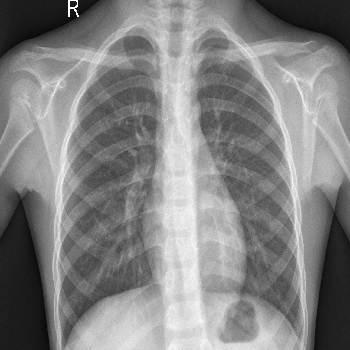

In [62]:
test_image_batch, label_batch = next(test_generator)

image = Image.fromarray((test_image_batch[0] * 255).astype('uint8').squeeze())

image

In [63]:
label_batch[:32]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

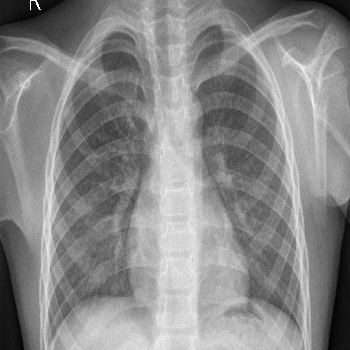

In [64]:
image = Image.fromarray((test_image_batch[11] * 255).astype('uint8').squeeze())

image

In [65]:
messages = [
    {
        "role": "system",
        "content": [{"type": "text", "text": "You are an expert radiologist."}]
    },
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Describe this X-ray ดูว่าเป็น Pneumonia หรือไม่ (ตอบสั้นกระชับเป็นภาษาไทย)"},
            {"type": "image", "image": image}
        ]
    }
]

In [66]:
output = pipe(text=messages, max_new_tokens=300)
print(output[0]["generated_text"][-1]["content"])

จากภาพ X-ray ที่ให้มา ดูเหมือนจะไม่พบภาวะปอดบวม (Pneumonia) โดยทั่วไปแล้ว ปอดจะปรากฏเป็นสีขาว (lucent) เนื่องจากเป็นอากาศ แต่ภาพนี้ไม่มีลักษณะที่บ่งบอกถึงการอักเสบหรือการสะสมของของเหลวในปอด



In [67]:
image_array = np.array(image)
image_array.shape

(350, 350)

In [68]:
image_array = image_array.reshape(1, img_size[0], img_size[1], 1)

In [69]:
image_array.shape

(1, 350, 350, 1)

In [70]:
image_array = image_array / 255.0

In [71]:
cnn_prediction = model.predict(image_array)

predicted_class_index = (cnn_prediction > 0.5).astype("int32")[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [72]:
predicted_class_index

np.int32(0)

In [73]:
labels

['normal', 'opacity']

In [74]:
predicted_class_label = labels[predicted_class_index]

print(f"CNN Model Prediction: {predicted_class_label}")
print(f"Prediction Probability: {cnn_prediction[0][0]:.4f}")

CNN Model Prediction: normal
Prediction Probability: 0.1315


In [75]:
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f"Last convolutional layer name: {last_conv_layer_name}")

Last convolutional layer name: last_conv_layer


In [76]:
from tf_keras_vis.gradcam import Gradcam

In [77]:
gradcam = Gradcam(model, model_modifier=None, clone=True)

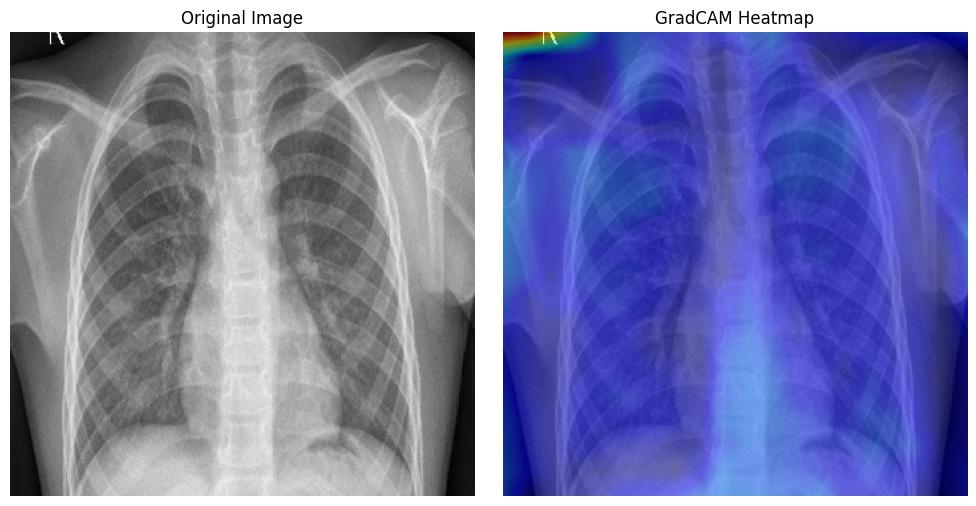

In [78]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

def custom_score(output):
    return output

heatmap = gradcam(custom_score,
                  image_array,
                  penultimate_layer=last_conv_layer_name)

heatmap = heatmap[0]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display original image
axes[0].imshow(image.convert('RGB'))
axes[0].set_title('Original Image')
axes[0].axis('off')

# Display GradCAM heatmap
axes[1].imshow(image.convert('RGB'))
axes[1].imshow(heatmap, cmap='jet', alpha=0.5) # Overlay the heatmap
axes[1].set_title('GradCAM Heatmap')
axes[1].axis('off')

plt.tight_layout()
plt.show()